In [93]:
# --- about
# this file starts with notebook 'three datasets' and adds bootstrapping 

# notebooks left to do:
# testing algorithms on pure spectra only, no mixtures
# kfold
# do multiple runs and record mean and variance of results

In [94]:
# --- set up environment

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.artist as art
from sklearn.decomposition import FastICA

# for Set working folder, etc.
import os
import os.path

# for sampling 
import random

# test code
# print(os.getcwd())

In [95]:
# --- etl spectrum files

# turn files into lists and cut off first line
# put into database "spectra"
# turn deleted points (flagged as -1.23e+34) into 0's
# label spectra with datafile titles


# - init spectra and class databases
datafolder = "C:/Users/Bonita/Documents/GitHub/spectra-analysis/data/data3"
num_samples = len([name for name in os.listdir(datafolder) if \
                   os.path.isfile(os.path.join(datafolder,name))])
# test code 
# print(num_samples)

spectrum_len = 480                                 # 480 >= the BECK spectrometer spectrum length
spectra = np.zeros((num_samples,spectrum_len))
spectrum_categories = np.zeros(num_samples)
first_record_of_mixtures_chapter = 11602
is_a_mineral = 1                                   # these numbers match the chapter numbers given by usgs
is_a_mixture = 2
spectrum_names = ["" for x in range(num_samples)]

y = np.zeros((num_samples, 1))


# - fill databases
i = 0

# find spectra folder
os.chdir(datafolder)

# - etl the data
# - create a spectrum_names string matrix for populating the plot legends
# - find record number for identifying mixtures, which will be plotted in thicker lines
for filename in os.listdir(datafolder):
    
    # read file
    file_object  = open(filename, 'r').readlines()
    # strip off header, add to matrix 'spectra'
    spectra[i,:] = file_object[1:]                  
    
    # find file header
    file_header = file_object[0]             
                                        
    # make spectrum_names matrix to label spectra in the plot legends
    spectrum_names[i] = file_header
    
    # categorize spectrum as mineral or mixture:
    # find record number in the header 
    # change from string to integer
    # use it to identify and label minerals versus mixtures
    # (minerals are records <=first_record_of_mixtures_chapter)
    # (see report pg 3 from https://pubs.er.usgs.gov/publication/ds1035 
    # ...for list of categories, 'chapters')
    # (*will need to update if we want to use and categorize spectra from other categories)
    # store category in spectra_category
    ####
    start = 'Record='
    end = ':'
    record_number = int((file_header.split(start))[1].split(end)[0])
    # print(record_number)
    if record_number < first_record_of_mixtures_chapter:
        spectrum_categories[i] = is_a_mineral
    else:
        spectrum_categories[i] = is_a_mixture
        
    # testcode
    # print('record_number: ', record_number)
    
    # testcode
    # print(spectrum_categories)
    
    # testcode
    # print(file_header)
    
    # label spectrum class, based on header
    # actinolite: 0, alunite: 1, chlorite: 2
    if file_header.find('Actinolite',)!= -1: #if material name contains actinolite
        y[i,0] = 0
    elif file_header.find('Alun',)!= -1:
        y[i,0] = 1
    else:                                       #chlorite
        y[i,0] = 2         
               
    # turn deleted points into 0
    for j in range(spectrum_len):  
        if spectra[i,j] <0:
            spectra[i,j]=0                          
    i+=1

# test code
# print(y[:])
# print(spectra[0:2,0])

In [96]:
# --- etl 

# divide up data randomly into train, dev and test populations

# 60% training set, 20% validation set, 20% test set 
sample_indices = list(range(0, num_samples))
random.shuffle(sample_indices)
train_population_size = 3*(num_samples//5)
dev_population_size = (num_samples//5)
test_population_size= num_samples-dev_population_size - train_population_size
train_population_indices = sample_indices[1:train_population_size]
dev_population_indices = sample_indices[train_population_size: train_population_size+dev_population_size]
test_population_indices= sample_indices[train_population_size+dev_population_size: num_samples]
print(test_population_indices)

#testcode
#print(type(np.setdiff1d(sample_indices,train_set_indices)))
      
#dev_set_indices = random.sample(np.setdiff1d(sample_indices,train_set_indices), dev_set_size) #sample remaining spectra

    

# test code
# print(train_set_size)
# print(dev_set_size)
# print(test_set_size)

# test code
# print(train_set_indices)
# print(test_set_indices)

[2, 22, 25, 18, 27, 12]


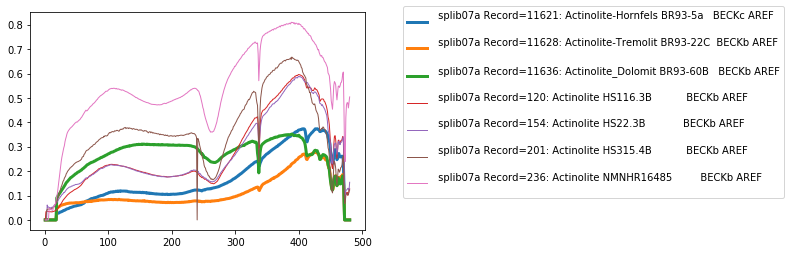

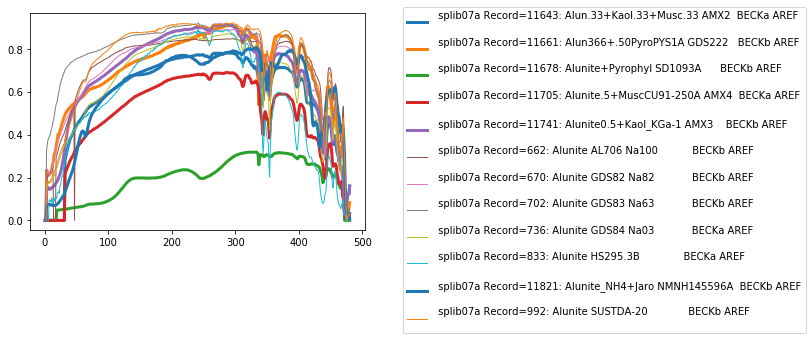

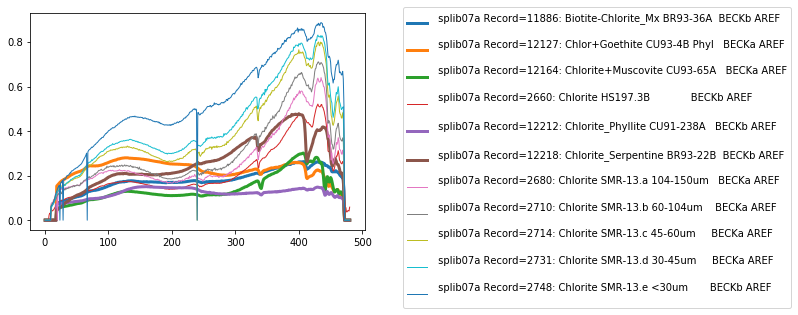

In [97]:
# --- plot the classes

# plot each class in a separate plot
# plot spectra names in legend
# plot minerals and mixtures w diff line widths

# variables
num0 = 0 #number of samples of class 0
num1 = 0
num2 = 0

mineral_linewidth = 1         # linewidth = 1 is default
mixture_linewidth = 3         

# count the number of each class to make spectra0, spectra1, spectra2 databases
for i in range(num_samples):
    if y[i,0]== 0:
        num0 += 1
    elif y[i,0]== 1:
        num1 += 1
    elif y[i,0]== 2:
        num2 += 1

# make class-specific databases spectra0, ...1, ...2
spectra0 = np.zeros((num0,spectrum_len)) 
spectra1 = np.zeros((num1,spectrum_len)) 
spectra2 = np.zeros((num2,spectrum_len)) 

labels0 = ["" for x in range(num0)]
labels1 = ["" for x in range(num1)]
labels2 = ["" for x in range(num2)]

linewidth0 = np.zeros(num0)
linewidth1 = np.zeros(num1)
linewidth2 = np.zeros(num2)


# make counters for each database to place spectra
i0 = 0
i1 = 0
i2 = 0

# set linewidth for the spectrum 
# populate class-specific databases spectra0, ...1, ...2
for i in range(num_samples):
    
    # set linewidth
    #testcode
    #print(spectrum_categories)
    #print(spectrum_categories[i])
    
    if spectrum_categories[i] == is_a_mineral:
        linewidth = mineral_linewidth
        
        #testcode
        #print('min')
    else: 
        linewidth = mixture_linewidth
        
        #testcode
        #print('mix')
    
    # populate matrices for making each class plot
    if y[i,0]== 0:
        spectra0[i0,:] = spectra[i,:]
        labels0[i0] = spectrum_names[i]
        linewidth0[i0] = linewidth
        i0 +=1
    elif y[i,0]== 1:
        spectra1[i1,:] = spectra[i,:]
        labels1[i1] = spectrum_names[i]
        linewidth1[i1] = linewidth
        i1 +=1
    else:
        spectra2[i2,:] = spectra[i,:]
        labels2[i2] = spectrum_names[i]
        linewidth2[i2] = linewidth
        i2 +=1

# plot each class-specific database separately
for i in range(i0):
    plt.plot(range(1, spectrum_len+1), spectra0[i,:], label = labels0[i], linewidth = linewidth0[i])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

for i in range(i1):
    plt.plot(range(1, spectrum_len+1), spectra1[i,:], label = labels1[i], linewidth = linewidth1[i])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

for i in range(i2):
    plt.plot(range(1, spectrum_len+1), spectra2[i,:], label = labels2[i], linewidth = linewidth2[i])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()  

In [98]:
# --- bootstrap sample the populations to make sets

# make train, dev, and test sets from their respective populations

train_set_size = train_population_size
dev_set_size = dev_population_size
test_set_size = test_population_size

#  draw with replacement from the populations
train_set_indices = random.choices(train_population_indices, k=train_set_size)
dev_set_indices = random.choices(dev_population_indices, k=dev_set_size)
test_set_indices = random.choices(test_population_indices, k=test_set_size)

# make train and test sets
train_set = spectra[train_set_indices, :]
train_set_labels = y[train_set_indices, :]
dev_set = spectra[dev_set_indices, :]
dev_set_labels = y[dev_set_indices,:]
test_set = spectra[test_set_indices, :]
test_set_labels = y[test_set_indices, :]

In [99]:
# --- kfold cross validation


In [100]:
# --- Generate ICA spectra 

# ICA Parameters
num_components = 15
# Create FastICA object
ica = FastICA(n_components=num_components)

# Fit ICA model
X = train_set.T
S_ = ica.fit_transform(X)
A_ = ica.mixing_  # Estimated independent components (mixing matrix)
print(X.shape)
print(S_.shape)
print(A_.shape)

#for i in range(A_.shape[1]):
#    plt.title('Component {}'.format(i))
#    plt.plot(A_[:,i])
#    plt.figure()

(480, 18)
(480, 15)
(18, 15)


C:\Users\Bonita\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


In [101]:
# --- make plain nn model

model = keras.Sequential([
    keras.layers.Dense(300, activation=tf.nn.relu),
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])

# compile
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train
model.fit(train_set, train_set_labels, epochs=15)

Epoch 1/15
18/18 [==============================] - 0s 25ms/step - loss: 1.2337 - acc: 0.2778
Epoch 2/15
18/18 [==============================] - 0s 0us/step - loss: 1.0641 - acc: 0.5000
Epoch 3/15
18/18 [==============================] - 0s 0us/step - loss: 1.0305 - acc: 0.4444
Epoch 4/15
18/18 [==============================] - 0s 0us/step - loss: 0.9805 - acc: 0.7222
Epoch 5/15
18/18 [==============================] - 0s 868us/step - loss: 0.9514 - acc: 0.6111
Epoch 6/15
18/18 [==============================] - 0s 0us/step - loss: 0.9256 - acc: 0.5556
Epoch 7/15
18/18 [==============================] - 0s 868us/step - loss: 0.8865 - acc: 0.6111
Epoch 8/15
18/18 [==============================] - 0s 0us/step - loss: 0.8496 - acc: 0.8333
Epoch 9/15
18/18 [==============================] - 0s 868us/step - loss: 0.8236 - acc: 0.7778
Epoch 10/15
18/18 [==============================] - 0s 0us/step - loss: 0.7968 - acc: 0.7778
Epoch 11/15
18/18 [==============================] - 0s 868us/

In [102]:
# --- test plain nn on dev set

dev_loss, dev_acc = model.evaluate(dev_set, dev_labels)

print('NN Dev accuracy:', dev_acc)

6/6 [==============================] - 0s 26ms/step
NN Dev accuracy: 0.3333333432674408


In [103]:
# --- transform train and dev set into components

train_transformed = S_[train_set_indices, :]
dev_transformed = S_[dev_set_indices, :]
print(train_transformed.shape)
print(dev_transformed.shape)

(18, 15)
(6, 15)


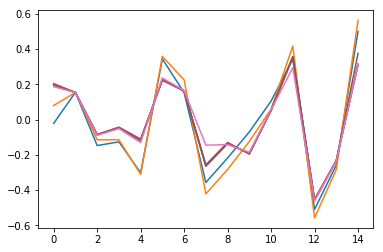

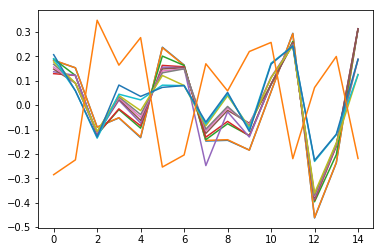

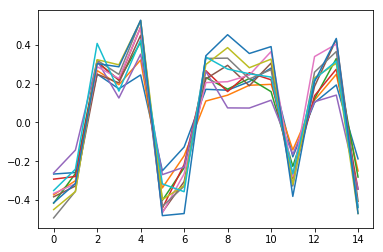

In [104]:
# --- visualize transformed spectra

# --- graph the classes

num0 = 0 #number of samples of class 0
num1 = 0
num2 = 0

# count the number of each class to make spectra0, spectra1, spectra2 databases
for i in range(num_samples):
    if y[i,0]== 0:
        num0 += 1
    elif y[i,0]== 1:
        num1 += 1
    elif y[i,0]== 2:
        num2 += 1

# make class-specific databases spectra0, ...1, ...2
icaspectra0 = np.zeros((num0, num_components)) 
icaspectra1 = np.zeros((num1, num_components)) 
icaspectra2 = np.zeros((num2, num_components)) 

# make counters for each database to place spectra
i0 = 0
i1 = 0
i2 = 0

# populate class-specific databases spectra0, ...1, ...2
for i in range(num_samples):
    if y[i,0]== 0:
        icaspectra0[i0,:] = S_[i,:]
        i0 +=1
    elif y[i,0]== 1:
        icaspectra1[i1,:] = S_[i,:]
        i1 +=1
    else:
        icaspectra2[i2,:] = S_[i,:]
        i2 +=1

# plot each class-specific database separately
for i in range(i0):
    plt.plot(icaspectra0[i,:])
plt.figure()

for i in range(i1):
    plt.plot(icaspectra1[i,:])
plt.figure()

for i in range(i2):
    plt.plot(icaspectra2[i,:])


In [105]:
# --- build NN on ICA model

model = keras.Sequential([
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])

# compile
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train on ica
model.fit(train_transformed, train_set_labels, epochs=20)

Epoch 1/20
18/18 [==============================] - 0s 28ms/step - loss: 1.0646 - acc: 0.0556
Epoch 2/20
18/18 [==============================] - 0s 0us/step - loss: 1.0458 - acc: 0.5000
Epoch 3/20
18/18 [==============================] - 0s 0us/step - loss: 1.0274 - acc: 0.6111
Epoch 4/20
18/18 [==============================] - 0s 0us/step - loss: 1.0092 - acc: 0.6111
Epoch 5/20
18/18 [==============================] - 0s 868us/step - loss: 0.9916 - acc: 0.6667
Epoch 6/20
18/18 [==============================] - 0s 0us/step - loss: 0.9742 - acc: 0.7222
Epoch 7/20
18/18 [==============================] - 0s 0us/step - loss: 0.9572 - acc: 0.7222
Epoch 8/20
18/18 [==============================] - 0s 868us/step - loss: 0.9405 - acc: 0.7222
Epoch 9/20
18/18 [==============================] - 0s 0us/step - loss: 0.9240 - acc: 0.7222
Epoch 10/20
18/18 [==============================] - 0s 0us/step - loss: 0.9077 - acc: 0.7222
Epoch 11/20
18/18 [==============================] - 0s 0us/step

In [106]:
# --- test nn on ica

dev_loss, dev_acc = model.evaluate(dev_transformed, dev_set_labels)

print('NN Test accuracy:', dev_acc)

6/6 [==============================] - 0s 31ms/step
NN Test accuracy: 0.3333333432674408
